In [2]:
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

font = 20
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': font,
    'axes.labelsize': font,  
    'xtick.labelsize': font,  
    'ytick.labelsize': font, 
    'legend.fontsize': font,
    'legend.title_fontsize': font
})

# solve setup for two users and one server as defined in Vardoyan et al., 2023

beta = 0.2 # attenuation in fiber
c_loss = 1 # other system losses

attempt_durations_l = [10 ** -3, 10 ** -3] # [s]

def Fidel(w):
    return (3*w+1)/4 

def D_H(w1,w2):
    F = Fidel(w1*w2)
    return 1 + F*np.log2(F) + (1-F) * np.log2((1-F)/3) if F > 0.81 else 1e-10 # yield of the so-called “hashing” protocol

def U_D(R, w1, w2): 
    val = np.log(R*D_H(w1,w2))
    return val

def Objective(x):
    R, w1, w2 = x
    return - 2*U_D(R, w1, w2) + (2*R - d_l[0]*(1-w1))**2 + (R - d_l[1]*(1-w2))**2 

res = {'Distance [km]':[], 'Server link':[], 'User link':[], 'Utility':[], 'Rate':[], 'Fidelity':[]}
for i in [1.5**k for k in np.linspace(1,11.5,15)]:
    distances_l = [i, 2] # [km]

    eta_l = 10 ** (-0.1 * beta * np.array(distances_l)/2) # transmissivity between one link end and midpoint station
    d_l = 3 * c_loss * eta_l / (2*np.array(attempt_durations_l))

    sol = minimize(Objective, x0=(75, 0.95, 0.95), bounds=( (1,80), (0.85,1.), (0.85,1.)), method='L-BFGS-B')
    rate, ws, wu = sol.x
    U = U_D(rate, ws, wu)

    res['Server link'].append(Fidel(ws))
    res['User link'].append(Fidel(wu))
    res['Utility'].append(2*U) # aggregated utility
    res['Fidelity'].append(Fidel(ws*wu))
    res['Rate'].append(rate) 
    res['Distance [km]'].append(i) 
df_res = pd.DataFrame.from_records(res)


/var/folders/d5/3r233ss93fv98nxsrp4wy_hc0000gn/T/ipykernel_66837/3290741941.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df_plot = df_res.melt(id_vars=['Distance [km]', 'Fidelity', 'Rate', 'Utility'], var_name='Type', value_name='Link Fidelity')

Text(0, 0.5, 'Fidelity')

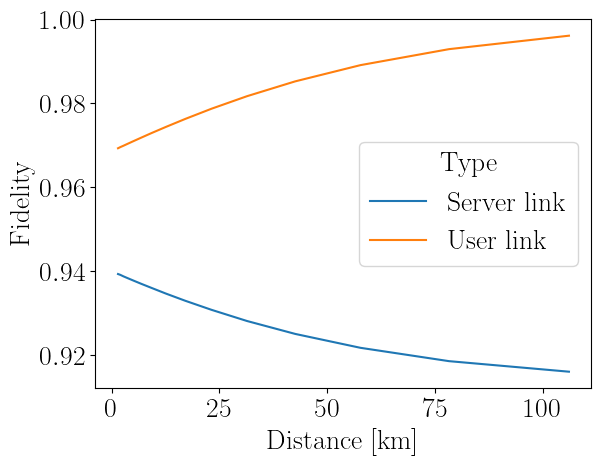

In [4]:
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')

<Axes: xlabel='Distance [km]', ylabel='Utility'>

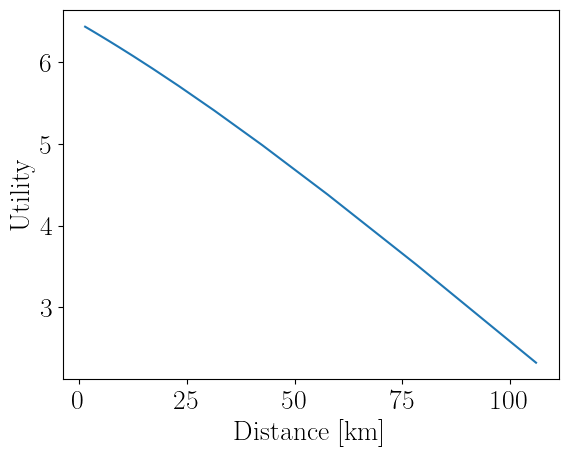

In [5]:
sns.lineplot(data=df_res, x='Distance [km]', y='Utility', markers=True)

(0.7, 1.0)

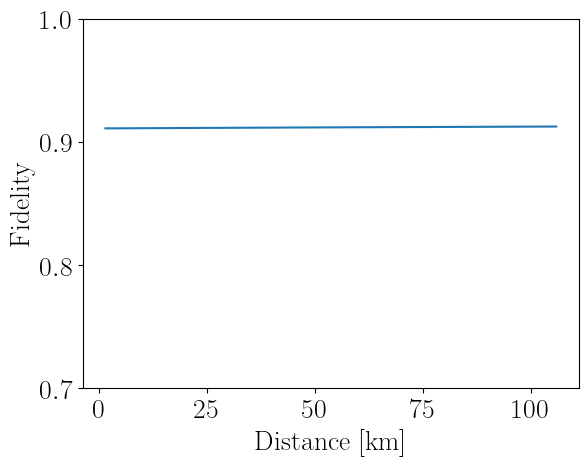

In [6]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True)
plt.ylim([0.7,1])

<Axes: xlabel='Distance [km]', ylabel='Rate'>

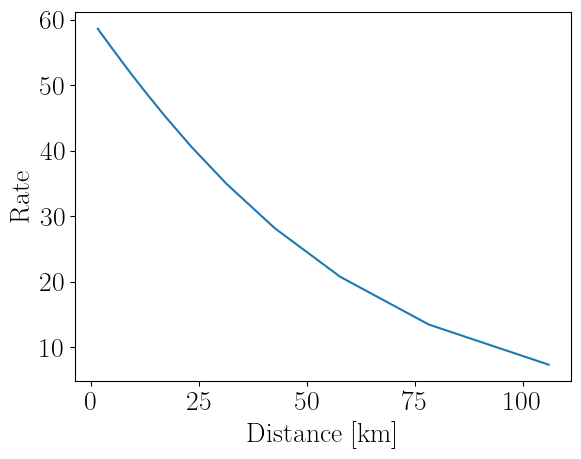

In [7]:
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True)

In [19]:
df = pd.read_csv('examples/Sur_df_qswitch_nleafnodes3_0.100h_bottleneck-link_SEED42_03-19-2024_18:00:12.csv')

In [20]:
df

,Unnamed: 0,bright_state_server,bright_state_user,Iteration,Fidelity,Fidelity_std,Rate,Rate_std,Utility,Utility_std,server_distance
0,0,0.061132,0.032691,1,0.908842,1.429470e-16,58.875,3.116459,6.390091,0.075275,1.500000
1,1,0.065368,0.027211,10,0.909792,1.064457e-16,48.815,2.781587,6.037328,0.080099,12.444444
2,2,0.062806,0.019978,15,0.918889,1.331163e-16,36.315,2.189401,5.650966,0.083409,23.388889
3,3,0.076270,0.021683,17,0.904253,1.440640e-16,34.910,2.299377,5.232612,0.094318,34.333333
4,4,0.063252,0.012879,1,0.924955,1.332954e-16,22.330,1.967847,4.803657,0.128090,45.277778
5,5,0.074491,0.013785,21,0.913093,1.974163e-16,21.240,1.626049,4.445507,0.109884,56.222222
6,6,0.065509,0.008316,7,0.926901,1.371978e-16,13.945,1.288723,3.902076,0.137038,67.166667
7,7,0.093783,0.014025,0,0.893946,2.013198e-16,15.835,2.220660,3.368203,0.201498,78.111111
8,8,0.080042,0.007224,15,0.913505,1.429332e-16,10.850,1.340092,3.103484,0.174302,89.055556
9,9,0.071548,0.018720,19,0.911518,1.284635e-16,7.605,1.843603,2.296684,0.362898,100.000000


Text(0.5, 0, 'Distance [km]')

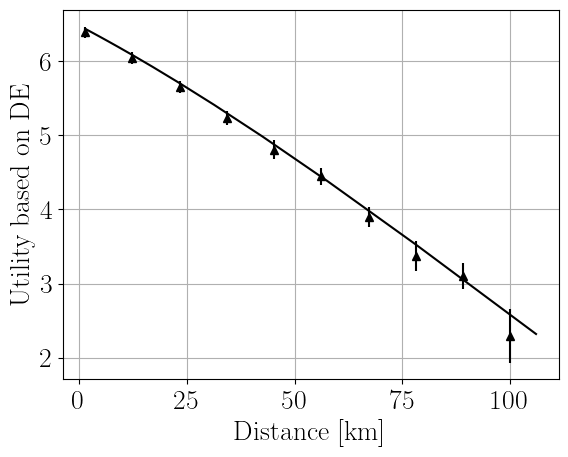

In [21]:
plt.errorbar(df['server_distance'], df['Utility'],df['Utility_std'], fmt='^', color='black')
sns.lineplot(data=df_res, x='Distance [km]', y='Utility', markers=True, color='black')
plt.grid()
plt.ylabel('Utility based on DE')
plt.xlabel('Distance [km]')

Text(0, 0.5, 'Fidelity')

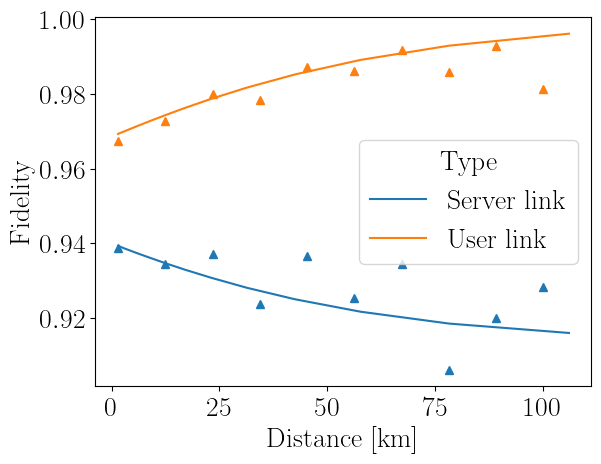

In [22]:
plt.plot(df['server_distance'], 1-df['bright_state_server'], '^')
plt.plot(df['server_distance'], 1-df['bright_state_user'], '^')
sns.lineplot(data=df_plot, x='Distance [km]', y='Link Fidelity', hue='Type', markers=True)
plt.ylabel('Fidelity')
plt.xlabel('Distance [km]')
plt.ylabel('Fidelity')

Text(0, 0.5, 'Rate [Hz]')

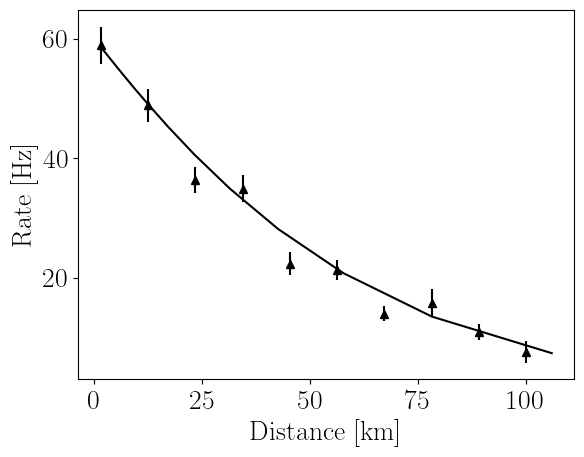

In [23]:
fig, ax1 = plt.subplots()
plt.errorbar(df['server_distance'], df['Rate'], df['Rate_std'], fmt='^' , color='black')
sns.lineplot(data=df_res, x='Distance [km]', y='Rate', markers=True, color='black', ax=ax1)
plt.xlabel('Distance [km]')
plt.ylabel('Rate [Hz]')

(0.7, 1.0)

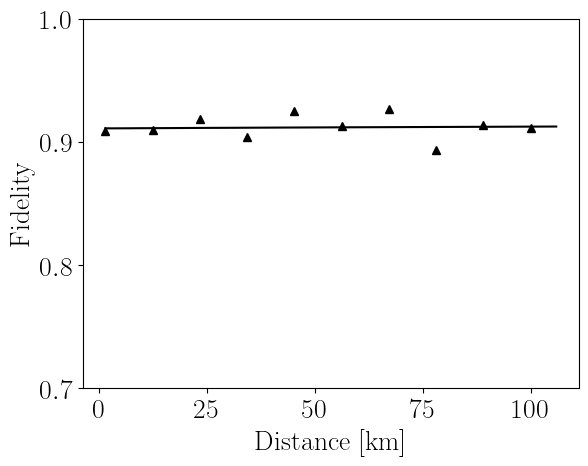

In [24]:
sns.lineplot(data=df_res, x='Distance [km]', y='Fidelity', markers=True, color='black')
plt.errorbar(df['server_distance'], df['Fidelity'], df['Fidelity_std'], fmt= '^', color='black' )
plt.ylim([0.7,1])

Werner states vs how we model depolarization in the simulation
$$\rho_{B00} = |\Psi^+><\Psi^+|$$
$$ \rho_w  = w \rho_{B00} + (1-w) \frac{I_4}{4}$$

$$\rho_{depol} = (1-\frac{3}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$ 
$$\rho_{depol} = (1-\frac{3}{4}p + \frac{1}{4}p - \frac{1}{4}p)I\rho_{B00}I + \frac{p}{4}(X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)I\rho_{B00}I + \frac{p}{4}(I\rho_{B00}I + X\rho_{B00}X + Y\rho_{B00}Y + Z\rho_{B00}Z)$$
$$\rho_{depol} = (1-p)\rho_{B00} + \frac{p}{4}I$$
$$\rightarrow w = 1-p$$

Link-level Fidelity
$$F = \frac{3w+1}{4} = 1-\alpha$$
$$\rightarrow w = 1 - \frac{4}{3}\alpha $$
$$\rightarrow p = 4/3\alpha $$

In [25]:
{'a':1} + {'b':2}

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'